# Comparison measurements and theory

## Theoretical model coming from 'High Sensitivity Magnetometers' chapter 4.

We use the following expressions:

General steady-state equations:

$$u_{ss} = \frac{-\delta \omega \tilde{\Omega}_{x'} + \gamma \tilde{\Omega}_{y'}}{\delta \omega^2+\gamma^2+\tilde{\Omega}_{x'}+\tilde{\Omega}_{y'}} S_0 cos(\theta_B)$$
$$v_{ss} = \frac{-\delta \omega \tilde{\Omega}_{y'} - \gamma \tilde{\Omega}_{x'}}{\delta \omega^2+\gamma^2+\tilde{\Omega}_{x'}+\tilde{\Omega}_{y'}} S_0 cos(\theta_B)$$
$$w_{ss} = \frac{\delta \omega^2 + \gamma^2}{\delta \omega^2+\gamma^2+\tilde{\Omega}_{x'}+\tilde{\Omega}_{y'}} S_0 cos(\theta_B)$$

Following a linearized version of Beer-Lambert, we have 
$$P \approx P_0 - P_0 \kappa L$$
and $$\kappa = \kappa_0^{unpol} \left[1-\alpha_{F,F'}\right]$$

As a general expression for the optical power, we have :
$$ P_{DC} = P_0 - P_0 \kappa_0^{unpol} L + P_0\kappa_0^{unpol} L \alpha_{F,F'}w_{ss} cos(\theta_B)$$
$$ P_{IP} = - P_0\kappa_0^{unpol} L \alpha_{F,F'}v_{ss} sin(\theta_B)$$
$$ P_{QU} = - P_0\kappa_0^{unpol} L \alpha_{F,F'}u_{ss} sin(\theta_B)$$

And finally:
$$ P(t) = P_{DC} + P_{IP} sin(\omega_{rf} t) + P_{QU} cos(\omega_{rf} t)$$

We add the coefficients $\mathscr{R} \approx 0.5$ the photodiode's responsivitiy and TIA_gain which accounts not only for the TIA gain, but for the empirical coefficient between what comes out of the photodiode and what is seen on the scope of the MFLI. 
Note: The photodiode's output is splitted between the laser and the MFLI, the laser part being used for locking the D1 transition.

## Updates 25.11.2025

Transmission before/after cell measured again, 1.2mW before cell, 0.63mW after cell, with or without RF doesn't change these values (must expect less than 0.01mW of difference in absorption then).

RF power measured properly, with the SR560 low noise pre amplifier. MFLI goes in SR560, SR560 goes to coil and oscilloscope, reading on oscilloscope in V /100 /0.05 gives the A. We measured 9.3mV, hence 1.86mA. This gives us a $|B_{RF}| = 1.46 \mu T$

In [1]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import display, HTML
from scipy.constants import *

## Simulation

In [2]:
## constants
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
g_F = 0.5006
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)
Gamma_natural = 36.10e6 # Natural linewidth (Hz)
I_sat = 44.84              # Saturation intensity (W/m²)
P_sat = 35.2e-3 # for 1mm beam diameter

theta_rf = np.deg2rad(0)
theta_B = np.deg2rad(45)
phi_B = np.deg2rad(0)

f0 = 163.97e3 #Hz
B_rf = 1.46e-6 #let's assume B_rf // k // x
gamma_F = 7e9 #Hz/T
gamma = 16e3 #relaxation
P_0 = 1.2e-3
gamma_pump = gamma*P_0/P_sat
S_infty = 1/2
T = 273.15 + 80
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6
R_PD = 0.5 #A/W
TIA_gain = 0.022 #V/A  

S0 = S_infty*(gamma_pump/(gamma_pump+gamma))

r_e = 2.82e-15 #m, classical electron radius
c = 299792458
f = 1/3
L = 1.5e-3 #length of the cell
#kappa = (2*r_e*c*f)/Gamma_natural * n
kappa = 0.5/L #experimental value
alpha = 1  #Not sure, no value, might be the 1/137 something

In [3]:
## Functions

def R_op(I):
    return Gamma_natural * I / (I + I_sat)

def hz_to_rad(x_hz): 
    return 2.0 * np.pi * np.array(x_hz, dtype=float)

def compute_M_pump(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    return M_pump, amplitude, DC_val

def compute_M_pump_instant(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot - Delta
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    return M_pump, amplitude, DC_val


def compute_S_k(theta_rf, theta_B, phi_B, omega_0, B_rf,omega,t):
    delta_omega = omega-omega_0
    Omega = gamma_F*B_rf
    Omega_xp = Omega*np.sin(phi_B)*np.sin(theta_rf)
    Omega_yp = -Omega*np.sin(theta_B)*np.cos(theta_rf) - Omega*np.cos(theta_B)*np.cos(phi_B)*np.sin(theta_rf)

    u_ss = ((-delta_omega*Omega_xp + gamma*Omega_yp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    v_ss = ((-delta_omega*Omega_yp - gamma*Omega_xp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    w_ss = ((delta_omega**2 + gamma**2)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)

    S_DC = w_ss*np.cos(theta_B)
    S_IP = -v_ss*np.sin(theta_B)
    S_QU = -u_ss*np.sin(theta_B)

    S_k = S_DC + S_IP*np.sin(omega*t) + S_QU*np.cos(omega*t)

    return S_k, S_DC, S_IP, S_QU

def compute_P_k(P_0, theta_B, L, kappa, theta_rf, phi_B, omega_0, B_rf, omega, t):
    delta_omega = omega-omega_0
    Omega = gamma_F*B_rf
    Omega_xp = Omega*np.sin(phi_B)*np.sin(theta_rf)
    Omega_yp = -Omega*np.sin(theta_B)*np.cos(theta_rf) - Omega*np.cos(theta_B)*np.cos(phi_B)*np.sin(theta_rf)

    u_ss = ((-delta_omega*Omega_xp + gamma*Omega_yp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    v_ss = ((-delta_omega*Omega_yp - gamma*Omega_xp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    w_ss = ((delta_omega**2 + gamma**2)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)


    P_DC = P_0 - P_0*kappa*L + P_0*kappa*L*alpha*w_ss*np.cos(theta_B)
    P_IP = -P_0*kappa*L*alpha*v_ss*np.sin(theta_B)
    P_QU = -P_0*kappa*L*alpha*u_ss*np.sin(theta_B)

    P_k = P_DC + P_IP*np.sin(omega*t) + P_QU*np.cos(omega*t)

    return P_k, P_DC, P_IP, P_QU

def compute_P_k_fit(P_0, theta_B, L, kappa, theta_rf, phi_B,
                gamma, gamma_F, B_rf,
                f0, f, A_ip, A_qu, C):

    omega   = 2*np.pi * f
    omega_0 = 2*np.pi * f0
    delta_omega = omega - omega_0

    Omega = gamma_F * B_rf

    Omega_xp = Omega*np.sin(phi_B)*np.sin(theta_rf)
    Omega_yp = -Omega*np.sin(theta_B)*np.cos(theta_rf) \
               -Omega*np.cos(theta_B)*np.cos(phi_B)*np.sin(theta_rf)

    denom = (delta_omega**2 + gamma**2 + Omega_xp**2 + Omega_yp**2)

    u_ss = ((-delta_omega*Omega_xp + gamma*Omega_yp) / denom) * S0*np.cos(theta_B)
    v_ss = ((-delta_omega*Omega_yp - gamma*Omega_xp) / denom) * S0*np.cos(theta_B)
    w_ss = ((delta_omega**2 + gamma**2) / denom) * S0*np.cos(theta_B)

    P_DC = P_0 - P_0*kappa*L + P_0*kappa*L*alpha*w_ss*np.cos(theta_B)

    # sign now controlled by A_ip, A_qu
    P_IP = C * A_ip * (-P_0*kappa*L*alpha*v_ss*np.sin(theta_B))
    P_QU = C * A_qu * (-P_0*kappa*L*alpha*u_ss*np.sin(theta_B))

    return P_DC, P_IP, P_QU



def simulate_lockin_response(f_sweep,
                             P_0, theta_B, L, kappa, theta_rf, phi_B,
                             gamma, gamma_F, B_rf,
                             tau_dwell=0.01, fs=200e3,
                             R_PD=1.0, TIA_gain=1.0,
                             remove_mean=True):
    
    # Convert to rad units
    gamma_rad   = 2*np.pi*gamma
    gamma_F_rad = 2*np.pi*gamma_F

    # Bias field
    B0 = np.mean(f_sweep) / gamma_F
    omega_0 = 2*np.pi * gamma_F * B0

    X_demod = np.zeros_like(f_sweep)
    Y_demod = np.zeros_like(f_sweep)

    for i, f in enumerate(f_sweep):
        omega = 2*np.pi * f

        # Time block
        N_cycles = f * tau_dwell
        N_cycles_int = int(round(N_cycles))
        Nt = int(N_cycles_int * (fs / f))
        t_block = np.arange(Nt) / fs if Nt > 10 else np.arange(int(fs*tau_dwell)) / fs

        Pk, P_DC, P_IP, P_QU = compute_P_k(
            P_0, theta_B, L, kappa, theta_rf, phi_B,
            omega_0, B_rf, omega, t=0
        )

        P_t = P_DC + P_IP*np.sin(omega*t_block) + P_QU*np.cos(omega*t_block)

        if remove_mean:
            P_t -= np.mean(P_t)

        ref_cos = np.cos(omega * t_block)
        ref_sin = np.sin(omega * t_block)

        X = 2 * np.mean(P_t * ref_cos)
        Y = 2 * np.mean(P_t * ref_sin)

        X_demod[i] = X
        Y_demod[i] = Y

    # Apply gains at the very end
    X_demod *= R_PD * TIA_gain
    Y_demod *= R_PD * TIA_gain

    return X_demod, Y_demod

def simulate_lockin_fit(f_sweep, params,
                        P_0, L, kappa, theta_rf, phi_B, f0, B_rf,
                        gamma_F, alpha,
                        theta_B_override=None,
                        tau_dwell=0.01, fs=200e3):

    # Normal case: theta_B is part of params
    if theta_B_override is None:
        gamma, theta_B, A_ip, A_qu = params
    else:
        gamma, _, A_ip, A_qu = params   # ignore theta_B in params
        theta_B = theta_B_override       # use fixed value instead

    X_demod = np.zeros(len(f_sweep))
    Y_demod = np.zeros(len(f_sweep))

    omega_0 = 2*np.pi * f0

    for i, f in enumerate(f_sweep):

        omega = 2*np.pi * f
        t_block = np.arange(int(fs*tau_dwell)) / fs

        # ===== magnetic response =====
        delta_omega = omega - omega_0
        Omega = gamma_F * B_rf

        Omega_xp = Omega*np.sin(phi_B)*np.sin(theta_rf)
        Omega_yp = -Omega*np.sin(theta_B)*np.cos(theta_rf) \
                   -Omega*np.cos(theta_B)*np.cos(phi_B)*np.sin(theta_rf)

        denom = (delta_omega**2 + gamma**2 +
                 Omega_xp**2 + Omega_yp**2)

        u_ss = ((-delta_omega*Omega_xp + gamma*Omega_yp) / denom) * np.cos(theta_B)
        v_ss = ((-delta_omega*Omega_yp - gamma*Omega_xp) / denom) * np.cos(theta_B)
        w_ss = ((delta_omega**2 + gamma**2) / denom) * np.cos(theta_B)

        P_DC = P_0 - P_0*kappa*L + P_0*kappa*L*alpha*w_ss*np.cos(theta_B)

        P_IP = A_ip * (-P_0*kappa*L*alpha*v_ss*np.sin(theta_B))
        P_QU = A_qu * (-P_0*kappa*L*alpha*u_ss*np.sin(theta_B))

        P_t = P_DC + P_IP*np.sin(omega*t_block) + P_QU*np.cos(omega*t_block)
        P_t -= np.mean(P_t)

        ref_cos = np.cos(omega * t_block)
        ref_sin = np.sin(omega * t_block)

        X_demod[i] = 2*np.mean(P_t * ref_cos)
        Y_demod[i] = 2*np.mean(P_t * ref_sin)

    return X_demod, Y_demod



def combined_model(f, gamma, B_rf, theta_B):

    X_sim, Y_sim = simulate_lockin_response(
        f,
        P_0, theta_B, L, kappa, theta_rf, phi_B, f0, B_rf,
        gamma, gamma_F,
        tau_dwell=0.01,
        fs=200e3,
        R_PD=R_PD,
        TIA_gain=TIA_gain
    )

    return np.concatenate([X_sim, Y_sim])

def residuals(params, f_sweep, X_data, Y_data,
              P_0, L, kappa, theta_rf, phi_B, f0, B_rf,
              gamma_F, alpha):

    X_model, Y_model = simulate_lockin_fit(
        f_sweep, params,
        P_0, L, kappa, theta_rf, phi_B, f0, B_rf,
        gamma_F, alpha
    )

    X_norm = (X_model - X_data) / np.max(np.abs(X_data))
    Y_norm = (Y_model - Y_data) / np.max(np.abs(Y_data))

    return np.concatenate([X_norm, Y_norm])



In [4]:
B_0 = 163000/gamma_F
omega_0 = gamma_F*B_0*2*np.pi
omega = np.linspace(130000,200000,1000)
t = 1

signal, signal_DC, signal_IP, signal_QU = compute_S_k(theta_rf, theta_B, phi_B, omega_0, B_rf,omega,t)

Diagnostic summary:
  max |X_demod - P_QU| = 6.946e-08
  max |Y_demod - P_IP| = 2.086e-07
  mean(X_demod / P_QU) over nonzero points = 1.00813
  mean(Y_demod / P_IP) over nonzero points = 0.99867


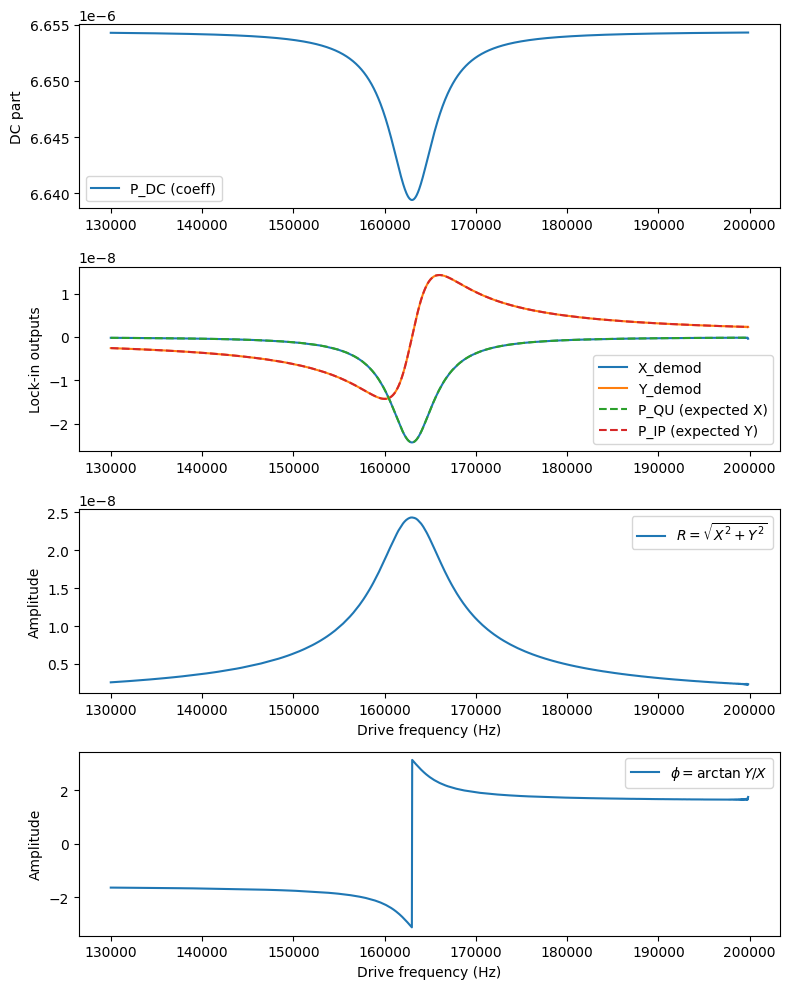

In [9]:
f_start = 130e3     # Hz
f_stop  = 200e3     # Hz
N_points = 2000      # number of sweep points (reduce for faster tests)
f_sweep = np.linspace(f_start, f_stop, N_points)  # Hz

# dwell / sampling
fs = 200e3         # sampling rate in Hz (choose >= ~8-10x f_stop)
tau_dwell = 0.010  # dwell time per frequency [s]
#Nt_block = int(np.round(tau_dwell * fs))

B0 = 163000.0 / gamma_F   # T  (you had this expression earlier)
omega_0 = hz_to_rad(gamma_F * B0)  # rad/s

# NOTE: gamma (relaxation) was in Hz; convert to rad/s to match omega units
gamma_rad = hz_to_rad(gamma)
gamma_F_rad = hz_to_rad(gamma_F)   # if needed inside compute_P_k (not always used)


X_demod = np.zeros_like(f_sweep)
Y_demod = np.zeros_like(f_sweep)
Pdc_arr  = np.zeros_like(f_sweep)
Pip_arr  = np.zeros_like(f_sweep)
Pqu_arr  = np.zeros_like(f_sweep)


for i, f in enumerate(f_sweep):
    omega = 2*np.pi * f    # rad/s, correct for sin(omega*t) usage

    N_cycles = f * tau_dwell     # scalar
    N_cycles_int = int(round(N_cycles))
    Nt_block = int(N_cycles_int * (fs / f))
    t_block = np.arange(Nt_block) / fs

    try:
        Pk, P_DC, P_IP, P_QU = compute_P_k(P_0, theta_B, L, kappa, theta_rf, phi_B, omega_0, B_rf, omega, t=0, A=-1)
    except NameError:
        raise RuntimeError("Please make sure compute_P_k is defined in the environment and has the expected signature.")
    except Exception as e:
        raise RuntimeError(f"compute_P_k call failed: {e}")

    Pdc_arr[i] = P_DC
    Pip_arr[i] = P_IP
    Pqu_arr[i] = P_QU

    # P(t) = P_DC + P_IP sin(omega t) + P_QU cos(omega t)
    P_t = ( P_DC + P_IP * np.sin(omega * t_block) + P_QU * np.cos(omega * t_block) )

    P_t = P_t - np.mean(P_t)

    # reference signals (same drive frequency)
    ref_cos = np.cos(omega * t_block) 
    ref_sin = np.sin(omega * t_block) 

    # demodulate by simple averaging (equivalent to LP with infinite flat pass) NOT SURE ABOUT THAT
    # For a pure P(t) = DC + IP*sin + QU*cos, we expect:
    #   X = 2 * mean(P_t * cos) --> QU
    #   Y = 2 * mean(P_t * sin) --> IP
    X_demod[i] = 2.0 * np.mean(P_t * ref_cos)
    Y_demod[i] = 2.0 * np.mean(P_t * ref_sin)


err_X = X_demod - Pqu_arr
err_Y = Y_demod - Pip_arr
print("Diagnostic summary:")
print(f"  max |X_demod - P_QU| = {np.max(np.abs(err_X)):.3e}")
print(f"  max |Y_demod - P_IP| = {np.max(np.abs(err_Y)):.3e}")
print(f"  mean(X_demod / P_QU) over nonzero points = {np.nanmean(np.where(np.abs(Pqu_arr)>0, X_demod / Pqu_arr, np.nan)):.5f}")
print(f"  mean(Y_demod / P_IP) over nonzero points = {np.nanmean(np.where(np.abs(Pip_arr)>0, Y_demod / Pip_arr, np.nan)):.5f}")


N_remove = 5
f_plot = f_sweep[:-N_remove]
Pdc_plot = Pdc_arr[:-N_remove] * R_PD * TIA_gain
Pqu_plot = Pqu_arr[:-N_remove] * R_PD * TIA_gain
Pip_plot = Pip_arr[:-N_remove] * R_PD * TIA_gain
X_plot = X_demod[:-N_remove] * R_PD * TIA_gain
Y_plot = Y_demod[:-N_remove] * R_PD * TIA_gain

plt.close('all')  
plt.figure(figsize=(8,10))

plt.subplot(4,1,1)
plt.plot(f_plot, Pdc_plot, label='P_DC (coeff)')
plt.ylabel('DC part')
plt.legend()

plt.subplot(4,1,2)
plt.plot(f_plot, X_plot, label='X_demod')
plt.plot(f_plot, Y_plot, label='Y_demod')
plt.plot(f_plot, Pqu_plot, '--', label='P_QU (expected X)')
plt.plot(f_plot, Pip_plot, '--', label='P_IP (expected Y)')
plt.ylabel('Lock-in outputs')
plt.legend()

plt.subplot(4,1,3)
plt.plot(f_plot, np.sqrt(X_plot**2 + Y_plot**2), label=r'$R = \sqrt{X^2 + Y^2}$')
plt.xlabel('Drive frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4,1,4)
plt.plot(f_plot, np.arctan2(Y_plot,X_plot), label=r'$\phi = \arctan{Y/X}$')
plt.xlabel('Drive frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


## Obsolete

In [ ]:
## Inputs
T = 273+80                    # Cell temperature (K)
B0 = 163e3/gamma                 # Static magnetic field (T)
B1 = 1.46e-6                # RF magnetic field (T) ESTIMATED IMPRECISELY
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 5e3           # Spin relaxation rate (Hz) ESTIMATED TO FIT THE WIDTH OF THE EXPERIMENTAL CURVES
beam_diameter = 1e-3       # Beam diameter (m)
z_cell = 1.5e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
R = 0.568                  # Photodiode responsivity (A/W)

## Derived Quantities
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
M0 = n * mu_eff                  # Max magnetization
omega_0 = gamma * B0              # Larmor frequency (rad/s)
print(omega_0)
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling

## Empirical data
P_in = 1.2e-3           # Laser power [W]
P_out0 = 0.63e-3       # Transmission without RF
T0 = P_out0 / P_in
OD0 = -np.log(T0)

I_laser = P_in / A_beam
R_op = Gamma_natural * I_laser / (I_laser + I_sat)
Gamma_tot = Gamma #+ R_op
delta = (gamma * B1 / (2*np.sqrt(2))) * np.sin(theta)

# AC magnetization prefactor
A = R_op * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)
# Frequency sweep

omega = np.linspace(130000, 200000, 1000)
Delta = omega - omega_0
t=np.linspace(0,1,1000)

chi_non_complex = (Gamma_tot*np.sin(omega*t) - Delta)*np.cos(omega*t) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))


M_pump_tot, _,_ = compute_M_pump_instant(t=t, R_op_val=R_op, M0=M0, delta=delta, theta=theta, Gamma=Gamma_tot,omega=omega, omega_0=omega_0)
M_pump_temp,_,_ = compute_M_pump(t=t, R_op_val=R_op, M0=M0, delta=delta, theta=theta, Gamma=Gamma_tot,omega=omega, omega_0=omega_0)

# Complex AC magnetization
chi = (Gamma_tot - 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_AC =  A*chi

M_AC_non_complex = A*chi_non_complex

## The minus sign comes form the fact that the magnetization will orient positively and will translate into more absorption
Y_sim = -np.real(M_AC)  # absorptive (dip)
X_sim = np.imag(M_AC)   # dispersive

OD_mod_real = OD0 * (1 + np.real(M_AC)/M0)
OD_mod = OD0 * (1 + M_AC/M0)

T = P_in * np.exp(-OD_mod)
T_tot = P_in * np.exp(-M_pump_tot/M0)


163000.0


Debugging the magnetization because it's not giving correct values according to me. Or i don't understand what's going, which is also very likely

In [ ]:
omega_vec = np.linspace(130000, 200000, 10000)
t_vec = np.linspace(0,0.001,1000)

results_raw = np.zeros((len(omega_vec), len(t_vec)))
M_pump = np.zeros(len(omega_vec))
for i,omega in enumerate(omega_vec):
    for j,t in enumerate(t_vec):
        results_raw[i, j],_,_ = compute_M_pump(t, R_op, M0, delta, theta, Gamma, omega, omega_0)
    M_pump[i] = np.max(results_raw[i,:]) - np.min(results_raw[i,:])


In [ ]:
M_pump_wtf = np.zeros(len(omega_vec))
for i in range(omega_vec):
    M_pump_wtf[i] = np.std(results_raw[i,:])

In [127]:
omega_0

163000.0

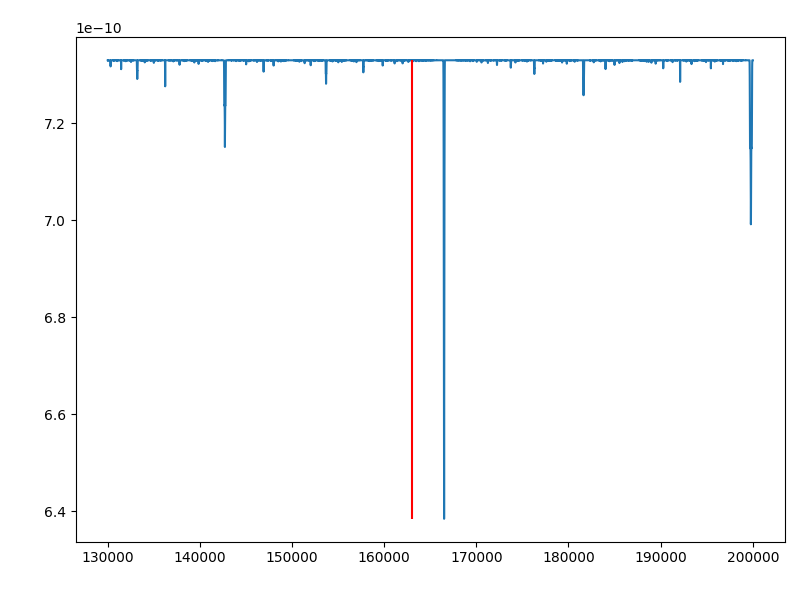

In [147]:
plt.clf()
plt.cla()
plt.plot(omega_vec,M_pump)
plt.vlines(x=163000, ymin = np.min(M_pump), ymax = np.max(M_pump), colors='r')
plt.show()

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Interactive plot function
def plot_oscillation(i):
    plt.figure(figsize=(8, 4))
    plt.plot(t_vec, results_raw[i, :])
    plt.xlabel("t (time)")
    plt.ylabel("M_pump(t)")
    plt.title(f"Oscillation at ω = {omega_vec[i]:.1f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Slider from 0 → len(omega_vec)-1
interact(
    plot_oscillation,
    i=IntSlider(min=0, max=len(omega_vec)-1, step=1, value=0)
)


interactive(children=(IntSlider(value=0, description='i', max=999), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_oscillation(i)>

### Absorption model

the absorption model is based on the theory from Scott J. Seltzer PhD thesis.

We start with the optical absorption from the following statement:
'Regardless of the form of the frequency response, the integral of the absorption cross-section associated with a given resonance is a constant:
$$\int_0^{+\infty} \sigma(\nu) d\nu = \pi r_e c f_{res}$$
where $r_e = 2.82 \times 10^{-15}m$ the classical electron radius[...]'

Is given later te profile of this cross section inthe case of the natural lifetime and pressure broadening :
$$\mathscr{L} (\nu - \nu_0) = \frac{\Gamma/2\pi}{(\nu - \nu_0)^2 + (\Gamma_L/2)^2}$$
Hence :
$$\sigma_L(\nu) = \pi r_e c f \mathscr{L}(\nu - \nu_0)$$

Assuming that we are at resonance, we have $\sigma(\nu_0) = \frac{2r_ecf}{\Gamma_L}$

Next step is the transmission:

$$\frac{d}{dz}I = -n\sigma(\nu)I (1-2s \langle S_z \rangle)$$
s being the light momentum ($\sigma^+$ gives s=+1, $\sigma^-$ gives s=-1, linear polarization gives s=0)

We assume that $2s\langle S_z \rangle = \langle M_{tot}(\omega_{RF}) \rangle$ MEGA FAUX

We assume that $M_{tot}$ doesn't change along z and we only vary $\omega_{RF}$. We thus have : 
$$I(z) = I_0 e^{-n \sigma(\nu_0)(1-M_{tot}\left(\omega_{RF})\right)z}$$
We are interested in z=l=1.5mm

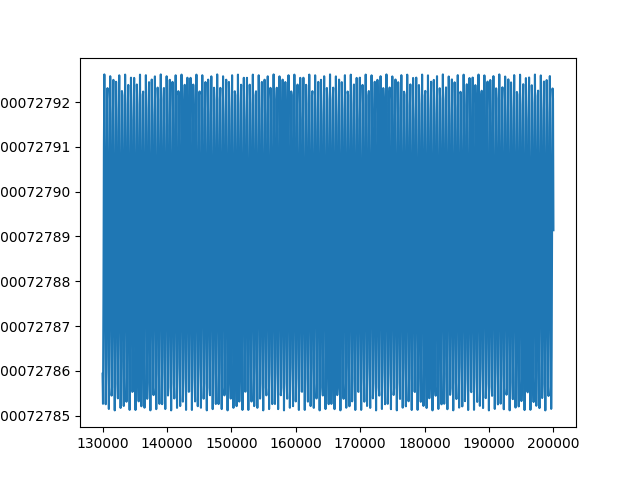

In [67]:
%matplotlib widget
plt.plot(omega, T_tot)
plt.show()

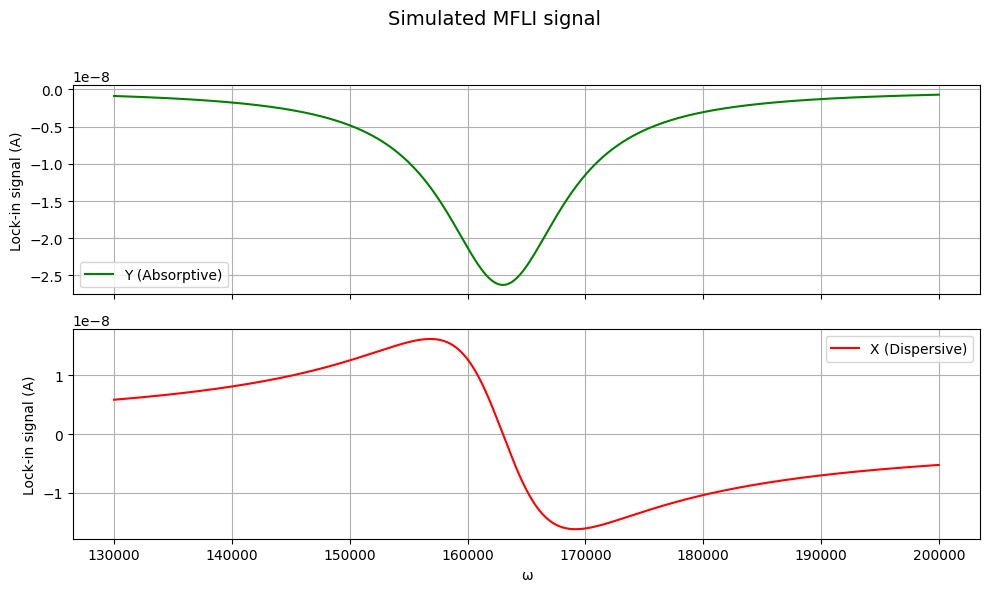

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# --- Top plot: Y_sim ---
ax[0].plot(omega, Y_sim, label='Y (Absorptive)', color='g')
ax[0].set_ylabel("Lock-in signal (A)")
ax[0].grid(True)
ax[0].legend()

# --- Bottom plot: X_sim ---
ax[1].plot(omega, X_sim, label='X (Dispersive)', color='r')
ax[1].set_xlabel("ω")
ax[1].set_ylabel("Lock-in signal (A)")
ax[1].grid(True)
ax[1].legend()

# Single shared title
fig.suptitle("Simulated MFLI signal", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Actual data

Current Data

In [5]:
filename = 'odmr_data/ODMR_serf_130k_200k_X_Y_current_HT.txt'

df = pd.read_csv(filename, 
                   comment='%', 
                   sep=';', 
                   names=['freq', 'X/Y'])

freq = df['freq'][:len(df['freq'])//2]
Y = df['X/Y'][:len(df['freq'])//2]
X = df['X/Y'][len(df['freq'])//2:]

freq = np.array(freq)
X = np.array(X)
Y = np.array(Y)

signal_stack = np.concatenate([X,Y])

### Stand alone fitting functions

In [17]:
# Basic Lorentzian
def lorentzian(f, A, f0, Gamma):
    return A * (0.5*Gamma)**2 / ((f - f0)**2 + (0.5*Gamma)**2)

# Fit a single Lorentzian in a frequency range
def fit_local_lorentzian(freq, amp, fmin, fmax):
    # select local range
    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]
    
    if len(f_local) == 0:
        return None, None
    
    # Initial guesses
    A0 = np.max(a_local) - np.min(a_local)
    f0_0 = f_local[np.argmax(a_local)]
    G0 = (fmax - fmin) / 10.0
    
    p0 = [A0, f0_0, G0]
    bounds = ([0, fmin, 1e-9], [np.inf, fmax, fmax-fmin])
    
    try:
        popt, pcov = curve_fit(lorentzian, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Fit failed in range", fmin, fmax, ":", e)
        return None, None
    
    return popt, pcov

def inverted_lorentzian(f, A, f0, Gamma, y0):
    """
    A: depth of the dip (positive number)
    f0: center frequency
    Gamma: full width at half maximum (FWHM)
    y0: baseline offset
    """
    return y0 - A * (0.5*Gamma)**2 / ((f - f0)**2 + (0.5*Gamma)**2)

# Fit a single inverted Lorentzian in a frequency range
def fit_local_inverted_lorentzian(freq, amp, fmin, fmax):
    # Convert to numpy arrays if needed
    freq = np.array(freq)
    amp = np.array(amp)

    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]

    if len(f_local) == 0:
        return None, None

    # Initial guesses
    A0 = np.max(a_local) - np.min(a_local)
    f0_0 = f_local[np.argmin(a_local)]
    G0 = (fmax - fmin) / 10.0
    y0_0 = np.max(a_local)

    p0 = [A0, f0_0, G0, y0_0]
    bounds = ([0, fmin, 1e-9, -np.inf], [np.inf, fmax, fmax-fmin, np.inf])

    try:
        popt, pcov = curve_fit(inverted_lorentzian, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Fit failed in range", fmin, fmax, ":", e)
        return None, None

    return popt, pcov

def dispersive(f, A, f0, Gamma, y0):
    d = f - f0
    return y0 + A * (d * (0.5*Gamma)) / (d**2 + (0.5*Gamma)**2)


def fit_local_dispersive(freq, amp, fmin, fmax):
    freq = np.array(freq)
    amp = np.array(amp)

    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]

    if len(f_local) == 0:
        return None, None

    # Initial guesses
    f0_guess = f_local[np.argmin(np.abs(a_local - np.mean(a_local)))]  # zero-crossing approx
    A0 = (np.max(a_local) - np.min(a_local))
    G0 = (fmax - fmin)/10
    y0_0 = np.mean(a_local)

    p0 = [A0, f0_guess, G0, y0_0]
    bounds = ([-np.inf, fmin, 1e-9, -np.inf],
              [ np.inf, fmax, (fmax-fmin),  np.inf])

    try:
        popt, pcov = curve_fit(dispersive, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Dispersive fit failed:", e)
        return None, None

    return popt, pcov

def linear_fit(x, y, xmin=None, xmax=None):
    x = np.asarray(x)
    y = np.asarray(y)

    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)

    mask = (x >= xmin) & (x <= xmax)

    if np.sum(mask) < 2:
        raise ValueError("Not enough points in the selected range for a linear fit.")

    x_sel = x[mask]
    y_sel = y[mask]

    m, b = np.polyfit(x_sel, y_sel, 1)

    y_fit = m * x_sel + b

    return m, b, x_sel, y_fit

### Theoretical expression fit

In [7]:
from scipy.optimize import least_squares


p0 = [
    16e3,              # gamma (Hz)
    np.deg2rad(45),          # theta_B
    1.0,              # A_ip
    1.0,              # A_qu
]

bounds = (
    [1,        0.0,   -5,   -5,],   # lower
    [100e5,  2*np.pi,   5,    5]    # upper
    #gamma,  theta_B,  A_ip, A_qu
)

result = least_squares(
    residuals,
    p0,
    args=(freq, X, Y, P_0, L, kappa, theta_rf, phi_B, f0, B_rf, gamma_F, alpha),
    bounds=bounds,
    verbose=2
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5564e+09                                    6.60e+11    
       1              2         8.5278e+07      1.47e+09       4.03e+03       3.72e+10    
       2              3         1.4644e+06      8.38e+07       2.14e+03       6.32e+08    
       3              4         1.3135e+03      1.46e+06       5.37e+02       5.43e+06    
       4              5         3.2359e+01      1.28e+03       4.58e+03       4.23e+05    
       5              6         7.3718e+00      2.50e+01       1.36e+04       4.84e+04    
       6              7         6.5526e+00      8.19e-01       4.64e+03       6.20e+03    
       7              8         6.5491e+00      3.46e-03       2.14e+02       3.84e+02    
       8             11         6.5491e+00      4.10e-05       3.20e+01       5.52e+01    
       9             15         6.5491e+00      1.77e-07       7.56e-04       5.55e+00    

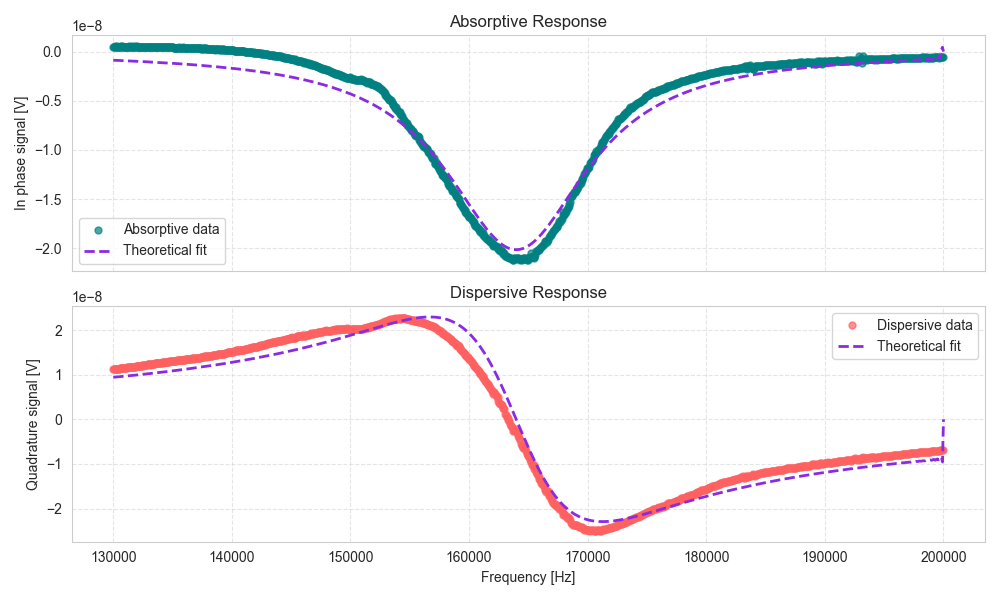


Fitted parameters:
gamma = 45380.84983609768 Hz
theta_B = 37.14956001696363 deg
A_ip = 0.0011783245735510093
A_qu = -0.0005217078030862883


In [8]:
X_fit, Y_fit = simulate_lockin_fit(
    freq, result.x,
    P_0, L, kappa, theta_rf, phi_B, f0, B_rf,
    gamma_F, alpha
)

import seaborn as sns
%matplotlib widget
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# First subplot: Absorptive data
axes[0].plot(freq, X, 'o', markersize=5, alpha=0.7, label='Absorptive data', color='teal')
axes[0].plot(freq, X_fit, '--', color='blueviolet', linewidth=2, label='Theoretical fit')
axes[0].set_ylabel('In phase signal [V]')
axes[0].set_title('Absorptive Response')
axes[0].grid(True, which='both', linestyle='--', alpha=0.5)
axes[0].legend()

# Second subplot: Dispersive data
axes[1].plot(freq, Y, 'o', markersize=5, alpha=0.7, label='Dispersive data', color="#FF6161")
axes[1].plot(freq, Y_fit, '--', color='blueviolet', linewidth=2, label='Theoretical fit')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Quadrature signal [V]')
axes[1].set_title('Dispersive Response')
axes[1].grid(True, which='both', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nFitted parameters:")
print("gamma =", result.x[0], 'Hz')
print("theta_B =", np.rad2deg(result.x[1]), 'deg')
print("A_ip =", result.x[2])
print("A_qu =", result.x[3])

Obtained data : 

| Parameter      | Value                |
|----------------|----------------------|
| $\gamma$       | 45,430.25 Hz         |
| $\theta_B$     | 37.14°               |
| $A_\mathrm{ip}$| 0.0011783            |
| $A_\mathrm{qu}$| -0.0005217           |


remarks : The gamma is fairly large, but expected. The field value is also expected. But the As and C value are curious. Maybe the coefficients from PD->MFLI do not capture well the discrepancy, or maybe there is some underlying problems from the model that are not accounted for. Still the value from P_QU and P_IP is reduced by 3 and 4 orders of magnitude. That would explain why it is so hard to observe the dip just from the scope, but is a tad worrying about self-oscillating scheme, since it is based on seeing oscillations directly.

Reminder of where the As and C parameters are : 
$$ P_{DC} = P_0 - P_0 \kappa_0^{unpol} L + P_0\kappa_0^{unpol} L \alpha_{F,F'}w_{ss} cos(\theta_B)$$
$$ P_{IP} = C  A_{ip} (- P_0\kappa_0^{unpol} L \alpha_{F,F'}v_{ss} sin(\theta_B))$$
$$ P_{QU} = C A_{qu} (- P_0\kappa_0^{unpol} L \alpha_{F,F'}u_{ss} sin(\theta_B))$$

$$ P(t) = P_{DC} + P_{IP} sin(\omega_{rf} t) + P_{QU} cos(\omega_{rf} t)$$

## Sensitivity estimation

to estimate the sensitivity, we will compare the phase signal and its fit
$$\phi = -arctan(\frac{Y}{X}) = \phi_0 - arctan(\frac{\delta \omega}{\gamma})$$
In the linear part of this curve, assuming $\delta \omega = 0$, we have : 
$$\Delta\phi = \Delta B \frac{d\phi}{dB} = \Delta B \frac{\gamma_F}{\gamma}$$

Now, we assume that $\gamma_F \Delta B = \Delta f$ (not sure how wrong it can be), which gives us then :
$$\Delta \phi = \frac{1}{\gamma} \Delta f$$
And we then take $\frac{1}{\gamma}$ as the slope of the linear regression

Slope_data = 0.0002263551034057535
Relaxation from data = 4417.837216629691
Slope_fit = 0.00028381022073591567
Relaxation from fit = 3523.481280579025


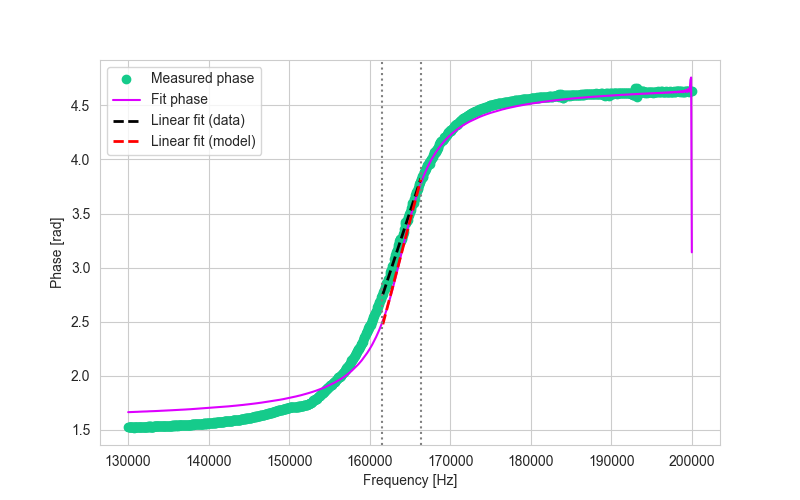

In [26]:
phi_fit = np.atan2(Y_fit,X_fit)
phi_fit = np.unwrap(phi_fit)
phi_data = np.arctan2(Y, X)
phi_data = np.unwrap(phi_data)

x_min_linear = f0-0.15*gamma
x_max_linear = f0+0.15*gamma

a_data, b_data, x_range_data, y_fit_data = linear_fit(freq, phi_data, xmin=x_min_linear, xmax=x_max_linear)
a_fit, b_fit, x_range_fit, y_fit_fit = linear_fit(freq, phi_fit, xmin=x_min_linear, xmax=x_max_linear)

print('Slope_data =', a_data)
print('Relaxation from data =', 1/a_data)
print('Slope_fit =', a_fit)
print('Relaxation from fit =', 1/a_fit)

plt.figure(figsize=(8,5))
plt.plot(freq, phi_data, 'o', label="Measured phase", color = "#15CB8B")
plt.plot(freq, phi_fit, '-', label="Fit phase", color = "#DD00FF")

plt.plot(x_range_data, y_fit_data, '--', color='black', linewidth=2,
         label='Linear fit (data)')
plt.plot(x_range_fit, y_fit_fit,  '--', color='red', linewidth=2,
         label='Linear fit (model)')

plt.axvline(x_min_linear, color='gray', linestyle=':')
plt.axvline(x_max_linear, color='gray', linestyle=':')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [rad]")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
1/a_data

np.float64(4417.837216629691)

notes to try :
- remove the C DONE
- normalization constants might not be so important for a phase measurements
- compute the sensitivity from the phase (dependant on the gamma) STRUGGLING
- 